## Visión por computador y redes convolucionales

La visión por computador siempre ha sido todo un reto y los avances en neurociencia, y más aún sobre cómo funciona nuestro sistema de visión, nos ha ayudado a comprender mejor cómo deberíamos estructurar nuestras arquitecturas para visión artificial.

![visual](https://gracewlindsay.com/wp-content/uploads/2018/05/fncom-08-00135-g001.jpg)

#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA. Prestad atención a las rutas de los datos y descargaros las imágenes del classroom. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

### Constantes
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
# Imágenes
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3 # color
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

# Tamaño lotes y épocas de entrenamiento
BATCH_SIZE = 100
EPOCHS = 25

### Descargamos los datos de entrenamiento

1. Descarga el dataset del campus
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador/ruta del entorno de trabajo.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [ ]:
# !pip install gdown

In [12]:
import gdown

url = 'https://drive.google.com/file/d/15K4Hlc2INrsCeThmjrEjM5saELmswmDM/view?usp=sharing'
output_path = 'dogsandcats.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=15K4Hlc2INrsCeThmjrEjM5saELmswmDM
From (redirected): https://drive.google.com/uc?id=15K4Hlc2INrsCeThmjrEjM5saELmswmDM&confirm=t&uuid=cadc23fe-5cc8-4e25-933b-5522ffe1abe0
To: /home/iraitz/TheBridge/B2B/DS4B2B/M3 - Deep learning/dogsandcats.zip
100%|██████████| 228M/228M [00:08<00:00, 26.0MB/s] 


'dogsandcats.zip'

In [13]:
import os
import zipfile

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall("data")

os.remove(output_path)

In [14]:
# Ruta del notebook
ROOT_PATH = os.getcwd()

# Extensión de la ruta a ./data/dogsandcats/train y test
TRAIN_PATH = os.path.join(ROOT_PATH, "data", "dogsandcats", "train")
TEST_PATH = os.path.join(ROOT_PATH, "data", "dogsandcats", "test")

Con esto podemos empezar nuestro trabajo.

In [15]:
import pandas as pd

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacía
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [16]:
df

,filename,category
0,dog.11766.jpg,1
1,dog.11482.jpg,1
2,cat.2314.jpg,0
3,cat.267.jpg,0
4,cat.1088.jpg,0
...,...,...
6571,dog.10469.jpg,1
6572,cat.1812.jpg,0
6573,cat.1674.jpg,0
6574,cat.3031.jpg,0


Veamos el total de imágenes que tenemos y cómo se distribuyen entre las distintas categorías.

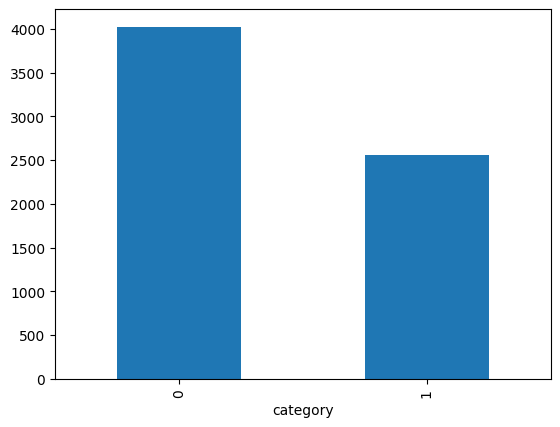

In [17]:
df['category'].value_counts().plot.bar();

Veamos una muestra de las imágenes.

In [19]:
# !pip install scikit-image opencv-python

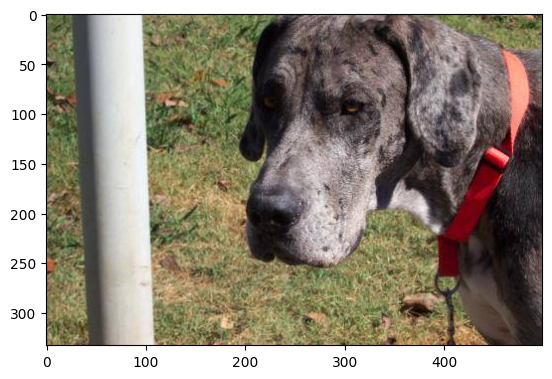

In [22]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image_path = os.path.join(TRAIN_PATH, sample)
image = imread(image_path)

plt.imshow(image);

Una imagen no es mas que una matriz de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. Podemos ver el objeto crudo simplemente por pantalla.

In [23]:
image

array([[[ 98, 123,  68],
        [113, 138,  83],
        [119, 143,  91],
        ...,
        [ 49,  42,  13],
        [ 59,  48,  20],
        [ 67,  56,  28]],

       [[108, 131,  77],
        [115, 140,  85],
        [118, 141,  89],
        ...,
        [ 66,  59,  30],
        [ 77,  68,  37],
        [ 88,  77,  49]],

       [[ 95, 115,  64],
        [ 95, 118,  66],
        [102, 122,  71],
        ...,
        [ 75,  69,  37],
        [ 84,  78,  44],
        [ 98,  89,  58]],

       ...,

       [[135, 122,  80],
        [129, 116,  74],
        [162, 149, 105],
        ...,
        [ 42,  30,  30],
        [ 43,  31,  31],
        [ 44,  32,  32]],

       [[125, 116,  73],
        [125, 116,  73],
        [155, 144,  99],
        ...,
        [ 42,  30,  30],
        [ 42,  30,  30],
        [ 43,  31,  31]],

       [[121, 116,  74],
        [120, 116,  71],
        [141, 134,  88],
        ...,
        [ 41,  29,  29],
        [ 42,  30,  30],
        [ 43,  31,  31]]

### Cambio de tamaño de la imagen

Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un `resize` a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

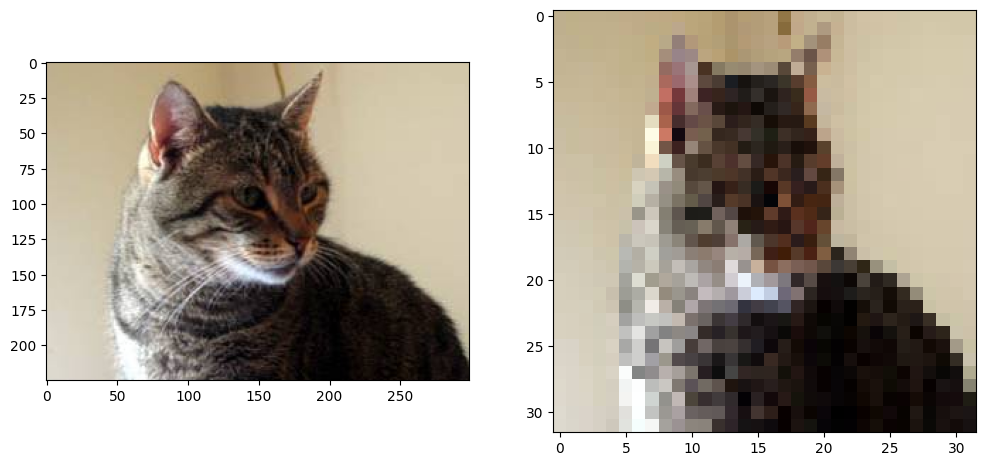

In [25]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image_path = os.path.join(TRAIN_PATH, sample)
image = imread(image_path)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

In [26]:
print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

Tamaño imagen original: (225, 299, 3)
Tamaño imagen reshape: (32, 32, 3)


# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

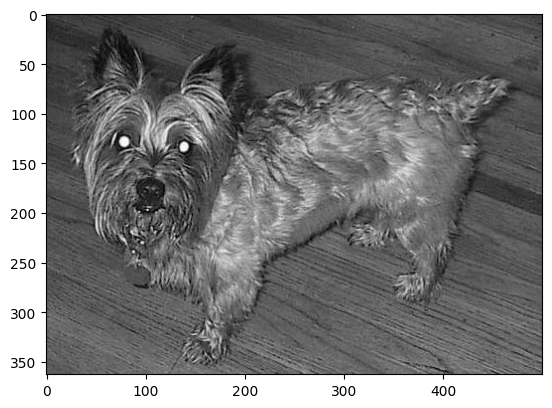

In [28]:
sample = random.choice(filenames)
image_path = os.path.join(TRAIN_PATH, sample)
image = cv2.imread(filename = image_path, flags = cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray');

In [29]:
print("Tamaño imagen original:", image.shape)

Tamaño imagen original: (363, 500)


# Cargamos los datos

Llega el momento de cargar los datos. Ya no es tan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [31]:
def read_data(path, im_size):
    X = []
    Y = []

    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image_path = os.path.join(path, file)
        image = imread(image_path)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print("Tamaño del conjunto de train: ", X_train.shape)
print("Tamaño del conjunto de test: ", X_test.shape)

Tamaño del conjunto de train:  (6576, 32, 32, 3)
Tamaño del conjunto de test:  (3456, 32, 32, 3)


Tamaño de la imagen  (32, 32, 3)


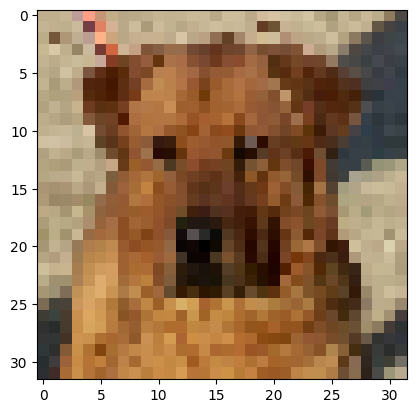

In [33]:
print("Tamaño de la imagen ", X_train[1].shape)
plt.imshow(X_train[1]);

In [14]:
X_train[0]

array([[[106, 128,  70],
        [ 99, 118,  60],
        [ 99, 118,  64],
        ...,
        [116, 140,  74],
        [132, 153,  94],
        [125, 149,  89]],

       [[119, 136,  82],
        [121, 138,  88],
        [102, 127,  73],
        ...,
        [126, 151,  87],
        [115, 145,  81],
        [108, 136,  75]],

       [[234, 229, 225],
        [237, 233, 232],
        [233, 230, 234],
        ...,
        [ 93, 123,  58],
        [105, 134,  76],
        [107, 135,  74]],

       ...,

       [[214, 206, 204],
        [163, 163, 168],
        [143, 132, 128],
        ...,
        [237, 232, 229],
        [236, 230, 230],
        [236, 230, 230]],

       [[157, 156, 163],
        [ 99,  96, 105],
        [ 64,  56,  52],
        ...,
        [234, 230, 227],
        [231, 226, 223],
        [238, 233, 230]],

       [[122, 116, 123],
        [139, 136, 143],
        [122, 120, 121],
        ...,
        [243, 238, 235],
        [237, 232, 228],
        [240, 231, 231]]

### Normalización
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala y ser las redes neuronales muy sensibles a los valores de activación e inhibición.

In [34]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [35]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


### Reordenamos

Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [36]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [37]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [38]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

Esto nos permite realizar este proceso una vez y simplemente añadir nuevas estructuras a futuro, saltándonos el paso de preprocesado para posteriores entrenamientos.

# Construcción del modelo

Sobre la estructura que vimos arriba, podemos diseñar capas que nos permitan extraer características base y en cada capa posterior componer estructuras más complejas que ayuden a identificar los objetos _observados_.

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

Podemos ver el paralelismo entre ambas redes

<img src="https://gracewlindsay.com/wp-content/uploads/2018/05/screenshot-from-2018-05-17-20-24-45.png" width="65%"/>

La esencia de las redes convolucionales es el hecho de aplicar un filtro uniforme a la imagen (llamado kernel) que nos permite extraer características concretas de esta. Gracias a que esos filtros son pequeños, el entrenamiento es mucho más ligero que si se tratara de redes densamente conectadas.

![](https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf)

Y podéis jugar con un ejemplo interactivo que emplea una red entrenada para el conjunto de datos de MNIST: https://adamharley.com/nn_vis/cnn/3d.html

Más detalle en: https://gracewlindsay.com/2018/05/17/deep-convolutional-neural-networks-as-models-of-the-visual-system-qa/ y https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks 

La arquitectura de nuestra red, tomando como ejemplo aquellas que en los artículos científicos han resultado más efectivas:

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para la pérdida (loss) y la métrica, se puede usar un **binary_crossentropy**, al ser un target binario tal y como hicimos [anteriormente](../M2%20-%20Fundamentos%20de%20ML/M2.1%20Familias%20de%20modelos/5.%20Redes%20neuronales.ipynb).

In [40]:
from tensorflow import keras

layers = [
    # Capa convolucional que reduce el tamaño a 62 matrices
    keras.layers.Conv2D(64, (3,3), activation='tanh', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Capa convolucional que reduce el tamaño a 128 matrices
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Capa final donde contamos con 128 valores
    keras.layers.Flatten(),

    # Sección para el clasificador
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

# Juntamos las capas
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,921 (2.57 MB)

 Trainable params: 673,921 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks
#### Early Stopping

In [42]:
from keras.callbacks import EarlyStopping

# Paramos de forma temprana
earlystop = EarlyStopping(patience=5)

In [43]:
from keras.callbacks import ModelCheckpoint

# Y guardamos modelos intermedios
mcheckpoint = ModelCheckpoint("callback_model.keras")

### Entrenamiento

Con todas las piezas ahora toca entrenar el modelo y ver qué tal resulta.

In [26]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2)

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6275 - loss: 0.6635 - val_accuracy: 0.6147 - val_loss: 0.6421
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6834 - loss: 0.5844 - val_accuracy: 0.6938 - val_loss: 0.5889
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7339 - loss: 0.5317 - val_accuracy: 0.6801 - val_loss: 0.5861
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7615 - loss: 0.4965 - val_accuracy: 0.7234 - val_loss: 0.5506
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7983 - loss: 0.4430 - val_accuracy: 0.7371 - val_loss: 0.5651
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8122 - loss: 0.4096 - val_accuracy: 0.7500 - val_loss: 0.5600
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8563 - loss: 0.3354 - val_accuracy: 0.7386 - val_loss: 0.5624
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8659 - loss: 0.3138 - val_accuracy: 0.7470 - v

### Evaluación

Probemos los datos en el conjunto de test.

In [27]:
results = model.evaluate(X_test, y_test)
results

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7510 - loss: 0.5950


[0.5917626619338989, 0.7462384104728699]

In [28]:
model.predict(X_test).round(0)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[1258,  390],
       [ 487, 1321]])

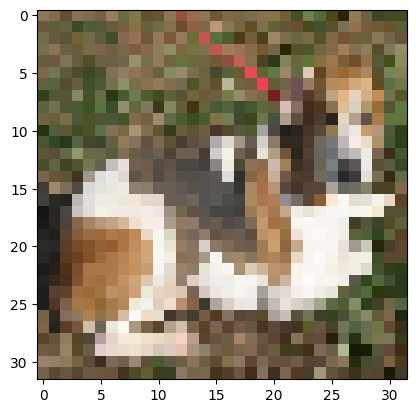

In [30]:
plt.imshow(X_test[-3]);

In [31]:
predictions = model.predict(X_test[-4:-3])
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.07472289]], dtype=float32)

### Variaciones

Deberemos garantizar que nuestro modelo aprende la estructura del objeto a identificar al margen de cómo se vea en la imagen (posición, rotación, iluminación, etc...)

In [45]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
print("Categorias:", df['category'].unique())
df.head()

Categorias: ['dog' 'cat']


,filename,category
0,dog.11766.jpg,dog
1,dog.11482.jpg,dog
2,cat.2314.jpg,cat
3,cat.267.jpg,cat
4,cat.1088.jpg,cat


Para esto podemos apoyarnos en funcionalidades como el `ImageDataGenerator` que tomando como base las imágenes empleadas, genera nuevas muestras rotando, haciendo zoom, etc. Esto permite a nuestro modelo aprender la estructura invariante de los objetos (qué cosas son un perro o un gato).

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

example_df = df.sample(n=1).reset_index(drop=True)
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (128, 128)
)

Found 1 validated image filenames belonging to 1 classes.


In [47]:
example_df

,filename,category
0,cat.1322.jpg,cat


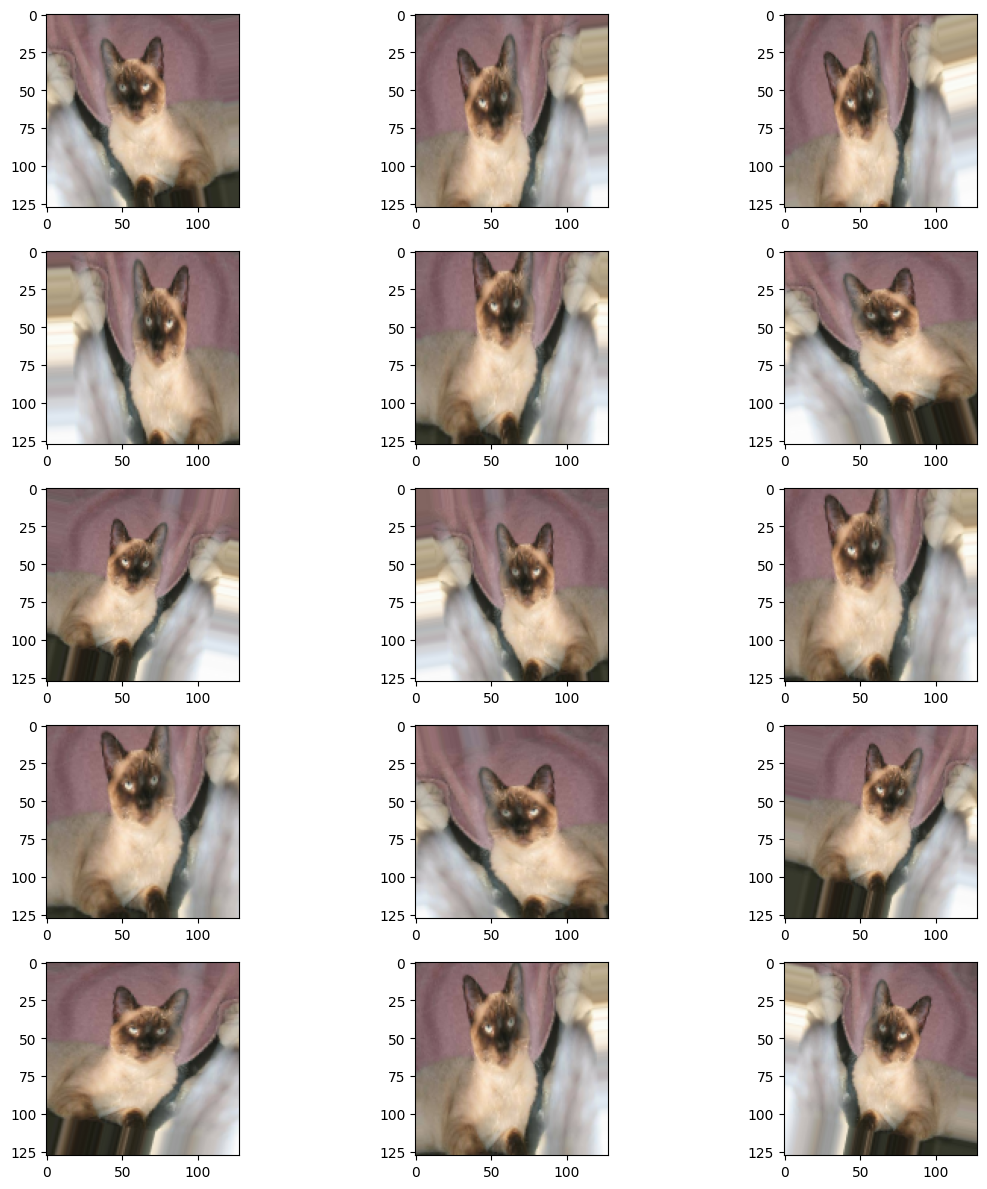

In [48]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [36]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [37]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 5260
Shape validation 1316


,filename,category
0,dog.12218.jpg,dog
1,dog.10656.jpg,dog
2,cat.3345.jpg,cat
3,dog.10471.jpg,dog
4,cat.2664.jpg,cat


In [38]:
train_df.head()

,filename,category
0,dog.11527.jpg,dog
1,dog.11720.jpg,dog
2,cat.1046.jpg,cat
3,cat.2644.jpg,cat
4,cat.3735.jpg,cat


In [39]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5260 validated image filenames belonging to 2 classes.


### Validación

In [40]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1316 validated image filenames belonging to 2 classes.


# Entrenamiento final

In [41]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [42]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/25


/home/iraitz/TheBridge/Otros/TheBridge_DSPT_ML/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7241 - loss: 0.5812 - val_accuracy: 0.8389 - val_loss: 0.4006
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7531 - loss: 0.5131 - val_accuracy: 0.7804 - val_loss: 0.4499
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.7512 - loss: 0.5065 - val_accuracy: 0.7515 - val_loss: 0.4949
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7715 - loss: 0.4915 - val_accuracy: 0.8237 - val_loss: 0.4171
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.7444 - loss: 0.4984 - val_accuracy: 0.8389 - val_loss: 0.3607
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7657 - loss: 0.4849 - val_accuracy: 0.8017 - val_loss: 0.4171
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7804 - loss: 0.4613 - val_accuracy: 0.7424 - val_loss: 0.4873
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.7820 - loss: 0.4607 - val_accuracy: 0.8214 - val_

In [43]:
import pandas as pd

# Listar todos los archivos de la carpeta de train (TEST_PATH)
filenames = os.listdir(TEST_PATH)

# Lista vacía
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')
    
# DataFrame
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [44]:
test_df

,filename,category
0,cat.10869.jpg,cat
1,cat.10981.jpg,cat
2,cat.11208.jpg,cat
3,dog.8845.jpg,dog
4,cat.10725.jpg,cat
...,...,...
3451,cat.11288.jpg,cat
3452,cat.11648.jpg,cat
3453,dog.8630.jpg,dog
3454,cat.11213.jpg,cat


In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 3456 validated image filenames belonging to 2 classes.


In [46]:
len(test_generator)

35

In [47]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7754 - loss: 0.4826
test loss, test acc: [0.4786517918109894, 0.7714120149612427]


# Visualización de la evolución

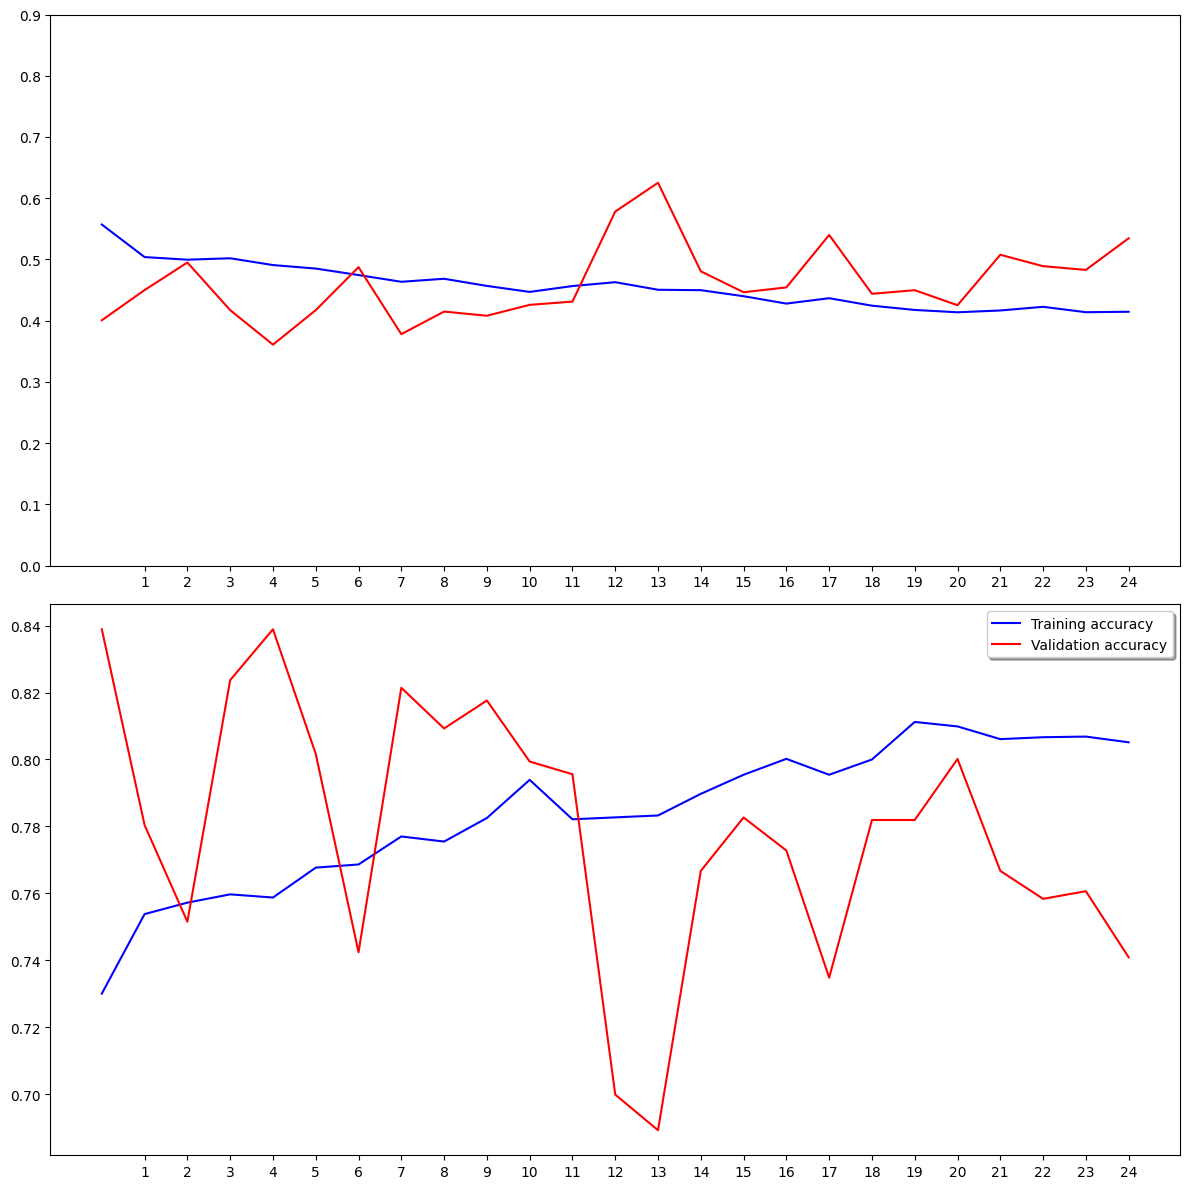

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podéis profundizar en esta temática gracias a estos recursos:

* [Foundations of Computer Vision](https://visionbook.mit.edu/)
* [Computer vision: Models, Learning, and Inference](https://udlbook.github.io/cvbook/)